In [1]:
import pymmmc

import aesara.tensor as at
import numpy as np
import pandas as pd

from aesara.tensor import TensorVariable

import pymc as pm

import matplotlib.pyplot as plt
import arviz as az

### Ground Truth Parameter Values

In [2]:
rng = np.random.RandomState(seed=34)
T = 10
T0 = 0

# individual-level model
lam = 0.5; p = 0.3

# random chosen individual model
a = b = alpha = r = 2

size = (5, 3)

### Sampling from the Prior

We will perform inference on the prior data to estimate the values of `lam` and `p` which have been set to 0.5 and 0.3 respectively.

In [3]:
with pm.Model():
    cnc = pymmmc.ContNonContract(
        name="cnc",
        lam=lam,
        p=p,
        T=T,
        T0=T0,
    )
    
    prior_data = pm.draw(cnc, draws=10000)

### Posterior Inference

In [4]:
with pm.Model() as model:

    λ = pm.Gamma(name="λ", alpha=0.1, beta=0.1)
    π = pm.Beta(name="π", alpha=0.1, beta=0.1)
    
    cnc = pymmmc.ContNonContract(
        name="cnc",
        lam=λ,
        p=π,
        T=T,
        T0=T0,
        observed=prior_data
    )
    
    trace = pm.sample(draws=30000, chains=1, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [λ, π]


Sampling 1 chain for 5_000 tune and 30_000 draw iterations (5_000 + 30_000 draws total) took 77 seconds.


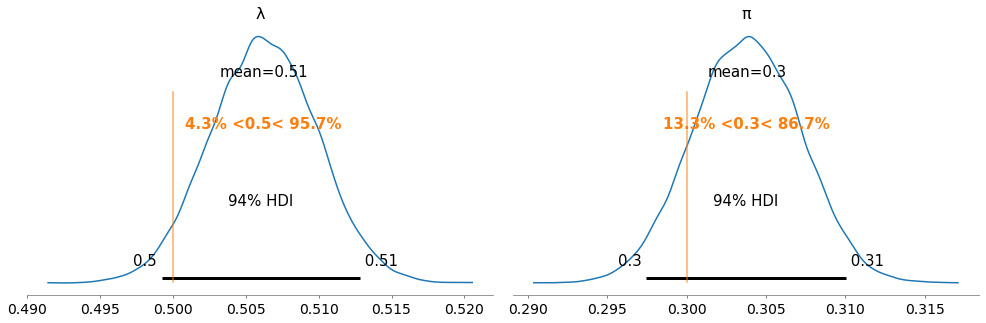

In [5]:
_ = az.plot_posterior(trace, ref_val=[lam, p])
plt.tight_layout()